In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Acknowledgements:**

Codes are taken from [Idiot Developer](https://www.youtube.com/watch?v=LkmgdNpcgTM&t=841s) and modified according to the need for this project.

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

if __name__ == "__main__":
    input_shape = (512, 512, 3)
    
    model = build_unet(input_shape)
    #model.summary()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
 

""" Global parameters """
H = 512
W = 512
def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path, split=0.2):
    images = sorted(glob(os.path.join(path,"Image", "*.png")))
    masks1 = sorted(glob(os.path.join(path,"Left", "*.png")))
    masks2 = sorted(glob(os.path.join(path,"Right", "*.png")))

    split_size = int(len(images) * split)          # we are calculating the split size here

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)  # training data and validation data will be selected randomly and the randomness seed is 42
    train_y1, valid_y1 = train_test_split(masks1, test_size=split_size, random_state=42)
    train_y2, valid_y2 = train_test_split(masks2, test_size=split_size, random_state=42)

     

    return (train_x, train_y1, train_y2), (valid_x, valid_y1, valid_y2) 

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path1, path2):
    x1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
    x2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
    x = x1 + x2
    x = cv2.resize(x, (W, H))
    x = x/np.max(x)
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y1, y2):
    def _parse(x, y1, y2):
        x = x.decode()
        y1 = y1.decode()
        y2 = y2.decode()

        x = read_image(x)
        y = read_mask(y1, y2)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y1, y2], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y1, Y2, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y1, Y2))
    dataset = dataset.shuffle(buffer_size=200)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(4)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 8
    lr = 1e-5
    num_epochs = 50
    model_path = os.path.join("files", "Final_model_unet.h5")
    csv_path = os.path.join("files", "Final_data_unet.csv")

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/Colab"
    (train_x, train_y1, train_y2), (valid_x, valid_y1, valid_y2)  = load_data(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y1)} - {len(train_y2)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y1)} - {len(valid_y2)}")
   

    train_dataset = tf_dataset(train_x, train_y1, train_y2, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y1, valid_y2, batch=batch_size)

    """ Model """
    model = build_unet((H, W, 3))
    metrics = [dice_coef, iou, Recall(), Precision()]
    #model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)
    # model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy"])
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy",metrics])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path)
    ]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Train: 1308 - 1308 - 1308
Valid: 326 - 326 - 326
Epoch 1/50
164/164 [==============================] - ETA: 0s - loss: 0.8224 - accuracy: 0.7763 - dice_coef: 0.1779 - iou: 0.0991 - recall: 0.9338 - precision: 0.1280
Epoch 1: val_loss improved from inf to 0.93046, saving model to files/model.h5
164/164 [==============================] - 1114s 7s/step - loss: 0.8224 - accuracy: 0.7763 - dice_coef: 0.1779 - iou: 0.0991 - recall: 0.9338 - precision: 0.1280 - val_loss: 0.9305 - val_accuracy: 0.1298 - val_dice_coef: 0.0695 - val_iou: 0.0360 - val_recall: 0.9929 - val_precision: 0.0382 - lr: 1.0000e-05
Epoch 2/50
164/164 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.9852 - dice_coef: 0.3901 - iou: 0.2433 - recall: 0.9523 - precision: 0.7162
Epoch 2: val_loss improved from 0.93046 to 0.87356, saving model to files/model.h5
164/164 [==============================] - 339s 2s/step - loss: 0.6099 - accuracy: 0.9852 - dice_coef: 0.3901 - iou: 0.2433 - recall: 0.9523 - prec

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
 
if __name__ == "__main__":
 
    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("files/Final_model_unet.h5")

    """ Dataset """
    path = "/content/drive/MyDrive/Test"
    test=sorted(glob(os.path.join(path, "*.png")))

    """ Predicting the mask """
    for x in tqdm( test, total=len(test )):
        """ Extracing the image name. """
        image_name = x.split("/")[-1]

        """ Reading the image """
        img = cv2.imread(x, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (W, H))
        x = img/255.0
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=0)

         

        """ Predicting the mask. """
        y_pred = model.predict(x)[0] > 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the predicted mask along with the image and GT """
        save_image_path = f"/content/drive/MyDrive/Results_test/{image_name}"
        y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

        sep_line = np.ones((H, 10, 3)) * 255

        output_image = np.concatenate([img,sep_line, y_pred*255], axis=1)
        #cat_image = np.concatenate([sep_line,y_pred*255,sep_line], axis=1) # this line for just the output segment
        #cat_image = np.concatenate([ori_x,sep_line,y_pred*255], axis=1) # this line for just the output segment and the test image
        cv2.imwrite(save_image_path, output_image)

100%|██████████| 145/145 [00:35<00:00,  4.05it/s]


Outputs

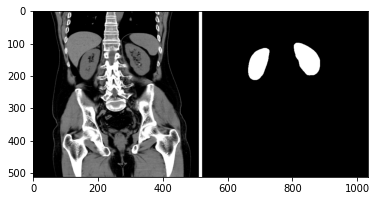

In [2]:
import cv2
import matplotlib.pyplot as plt

x=cv2.imread("opt.png")
x=cv2.cvtColor(x, cv2.COLOR_RGB2BGR)
plt.imshow(x)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
data=pd.read_csv("Final_data_unet.csv")
 

In [ ]:
print(data.head())

   epoch  accuracy  dice_coef       iou      loss       lr  precision  \
0      0  0.776284   0.177946  0.099066  0.822400  0.00001   0.127981   
1      1  0.985210   0.390065  0.243323  0.609936  0.00001   0.716223   
2      2  0.992031   0.470410  0.307866  0.529737  0.00001   0.834712   
3      3  0.993498   0.499227  0.332950  0.500817  0.00001   0.863348   
4      4  0.994522   0.520018  0.351776  0.479763  0.00001   0.883468   

     recall  val_accuracy  val_dice_coef   val_iou  val_loss  val_precision  \
0  0.933793      0.129814       0.069520  0.036018  0.930456       0.038240   
1  0.952332      0.927072       0.126261  0.067492  0.873564       0.198178   
2  0.961369      0.972882       0.390048  0.242541  0.609869       0.569959   
3  0.966058      0.993871       0.500406  0.333992  0.499427       0.870735   
4  0.970613      0.994480       0.524906  0.356233  0.475201       0.878577   

   val_recall  
0    0.992950  
1    0.359001  
2    0.902425  
3    0.967715  
4    0

In [ ]:
train_loss=data.iloc[:,4:5].values
 

In [ ]:
val_loss=data.iloc[:,11:12].values
 

In [ ]:
train_Acc=data.iloc[:,1:2].values
 

In [ ]:
val_Acc=data.iloc[:,8:9].values
 

In [ ]:
train_iou=data.iloc[:,3:4].values
 

In [ ]:
val_iou=data.iloc[:,10:11].values
 

In [ ]:
epoch=data.iloc[:,0:1].values

In [ ]:
print(f"Accuracy = {train_Acc[-1]*100}%")

Accuracy = [99.91780519]%


In [ ]:
print(f"IOU = {train_iou[-1]*100}%")

IOU = [80.89572787]%


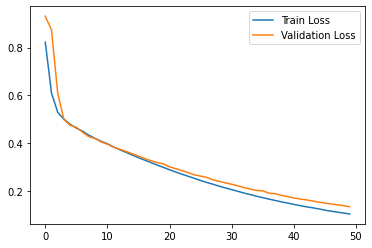

In [ ]:
plt.plot(epoch,train_loss,label='Train Loss')
plt.plot(epoch,val_loss,label='Validation Loss')
plt.legend()
plt.show()

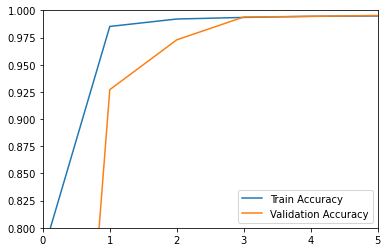

In [ ]:
plt.plot(epoch,train_Acc,label='Train Accuracy')
plt.plot(epoch,val_Acc,label='Validation Accuracy')
plt.xlim(0, 5)
plt.ylim(0.8, 1)
plt.legend()
plt.show()

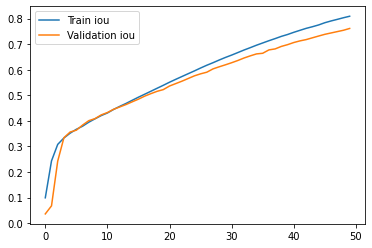

In [ ]:
plt.plot(epoch,train_iou,label='Train iou')
plt.plot(epoch,val_iou,label='Validation iou')
plt.legend()
plt.show()